
### Setting up PySpark in Colab

In [1]:
# Spark is written in the Scala programming language and requires the Java Virtual Machine (JVM) to run. Therefore, we download Java.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
# Download Apache Spark. You can find the link to the file at https://spark.apache.org/downloads.html 
!wget https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

--2021-12-02 18:59:29--  https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300965906 (287M) [application/x-gzip]
Saving to: ‘spark-3.2.0-bin-hadoop3.2.tgz’

spark-3.2.0-bin-had 100%[===================>] 287.02M   184MB/s    in 1.6s    

2021-12-02 18:59:31 (184 MB/s) - ‘spark-3.2.0-bin-hadoop3.2.tgz’ saved [300965906/300965906]



In [3]:
# Unzip Apache Spark with Hadoop 3.2
!tar xvzf spark-3.2.0-bin-hadoop3.2.tgz

spark-3.2.0-bin-hadoop3.2/
spark-3.2.0-bin-hadoop3.2/NOTICE
spark-3.2.0-bin-hadoop3.2/kubernetes/
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/python_executable_check.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/autoscale.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/worker_memory_check.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/py_container_checks.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/decommissioning.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/pyfiles.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/decommissioning_cleanup.py
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/decom.sh
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/bindings/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/bindings/R/
spark-3.2.0-bin-hadoop3.2/kubernetes/docker

In [4]:
!ls /content/spark-3.2.0-bin-hadoop3.2

bin   data	jars	    LICENSE   NOTICE  R		 RELEASE  yarn
conf  examples	kubernetes  licenses  python  README.md  sbin


In [5]:
# Set the ‘environment’ path
import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

In [6]:
# Install and import the ‘findspark’ library that will locate Spark on the system and import it as a regular library
!pip install -q findspark

import findspark
findspark.init()

In [7]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
.master("local") \
.appName("wild life") \
.getOrCreate()
# get a spark context from the session, and set verbose logging


In [8]:
spark.sparkContext

<SparkContext master=local appName=wild life>

### Install Pydrive

In [9]:
!pip install -U -q PyDrive

In [10]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

### Authentication

In [11]:
#After run this cell, click the link, and copy the token then input it
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Load File

In [12]:
fileDownloaded = drive.CreateFile({'id':'1NQT4x9C_pXFdRNjSobY-Yx3BlanlwalH'})

In [13]:
fileDownloaded.GetContentFile("WFIGS_-_Wildland_Fire_Locations_Full_History.csv")

In [14]:
df = spark.read.format("csv")\
    .options(header="true")\
    .load("WFIGS_-_Wildland_Fire_Locations_Full_History.csv")

In [15]:
df.show()

+-----------------+----------------+--------+--------+------------------+---------------+--------------------+--------------------+----------+--------------+----------------+-------------------+------------------------------+-----------------------------+---------------------------+-------------------+--------------------+--------------------+--------------------+---------+-------------------+-------------------+--------+----------------+---------------------+------------------+--------------------+--------------------------+---------------------------+--------------------------+----------------------------+---------+--------------+----+--------------------+-----------------------------+---------------------------+------------------+------------------------------+--------------------+------------------------+--------------------+----------------+---------------+----------------+--------------------+-----------------------+--------------------+-----------------------+-------------------

In [16]:
df.select("PrimaryFuelModel").groupBy("PrimaryFuelModel").count().show()

+--------------------+------+
|    PrimaryFuelModel| count|
+--------------------+------+
|      Brush (2 feet)|  1566|
|Medium Logging Slash|    92|
|Dormant Brush, Ha...|    86|
|Tall Grass (2.5 f...|  1683|
|Timber (Litter an...|  2243|
| Light Logging Slash|    50|
|Closed Timber Litter|   153|
|Short Grass (1 foot)|  2014|
|Timber (Grass and...|  2126|
|     Hardwood Litter|  1040|
|  Chaparral (6 feet)|   529|
| Heavy Logging Slash|    55|
|      Southern Rough|   804|
|                null|192076|
+--------------------+------+



 At first clean the data ,and keep meaningful data here:
 ABCD Misc,
 Calculated Acres ,
 start time,
 end time,
 Discovery Acres, 
 Fire Behavior General1234, 
 FireCause/General/Specific,
 Initial Latitude, 
 Initial Longitude,
 Primary Fuel Model, 
 Predominant Fuel Group, 
 Total Incident Personnel,
 Incident Type Category,
 Estimated Cost To Date,

### clean data

In [17]:
a = ['PrimaryFuelModel', 'Calculated Acres', 'Fire Discovery Date Time', 'Fire Out Date Time', 'Discovery Acres', 'Fire Behavior General1', 'Fire Behavior General2', 'Fire Behavior General3', 'Fire Behavior General', 'FireCause', 'FireCauseGeneral', 'FireCauseSpecific', 'Initial Latitude ', 'Initial Longitude', 'Predominant Fuel Group', 'Total Incident Personnel', 'Incident Type Category', 'Estimated Cost To Date', 'POO State']
for i in range(len(a)):
    a[i] = a[i].strip().replace(" ", "")
a

['PrimaryFuelModel',
 'CalculatedAcres',
 'FireDiscoveryDateTime',
 'FireOutDateTime',
 'DiscoveryAcres',
 'FireBehaviorGeneral1',
 'FireBehaviorGeneral2',
 'FireBehaviorGeneral3',
 'FireBehaviorGeneral',
 'FireCause',
 'FireCauseGeneral',
 'FireCauseSpecific',
 'InitialLatitude',
 'InitialLongitude',
 'PredominantFuelGroup',
 'TotalIncidentPersonnel',
 'IncidentTypeCategory',
 'EstimatedCostToDate',
 'POOState']

In [18]:
filterred_df = df.select(a)

In [19]:
filterred_df.show()

+----------------+---------------+---------------------+--------------------+--------------+--------------------+--------------------+--------------------+-------------------+---------+-------------------+-------------------+---------------+----------------+--------------------+----------------------+--------------------+-------------------+--------+
|PrimaryFuelModel|CalculatedAcres|FireDiscoveryDateTime|     FireOutDateTime|DiscoveryAcres|FireBehaviorGeneral1|FireBehaviorGeneral2|FireBehaviorGeneral3|FireBehaviorGeneral|FireCause|   FireCauseGeneral|  FireCauseSpecific|InitialLatitude|InitialLongitude|PredominantFuelGroup|TotalIncidentPersonnel|IncidentTypeCategory|EstimatedCostToDate|POOState|
+----------------+---------------+---------------------+--------------------+--------------+--------------------+--------------------+--------------------+-------------------+---------+-------------------+-------------------+---------------+----------------+--------------------+---------------

In [20]:
import pyspark.sql.functions as F
null_value = filterred_df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in filterred_df.columns]).collect()

In [21]:
##As you can see, there are too many null values! Therefore, we need to pay extra attention to the impact of null values during analysis. We should add necessary judgment conditions and find ways to obtain useful data in the presence of null values. 
null_value

[Row(PrimaryFuelModel=192076, CalculatedAcres=200032, FireDiscoveryDateTime=2, FireOutDateTime=80774, DiscoveryAcres=58939, FireBehaviorGeneral1=197975, FireBehaviorGeneral2=199654, FireBehaviorGeneral3=201309, FireBehaviorGeneral=192717, FireCause=26437, FireCauseGeneral=158863, FireCauseSpecific=192239, InitialLatitude=58115, InitialLongitude=58115, PredominantFuelGroup=174012, TotalIncidentPersonnel=194934, IncidentTypeCategory=5, EstimatedCostToDate=191748, POOState=6)]

In [22]:
# keep wild fire type，delete other types
filterred_df = filterred_df.filter(filterred_df.IncidentTypeCategory != 'CX')

In [24]:
# Look at the number of wildfires in each year, and add the year and month; but the date must be de-duplicated first 
filterred_df.na.drop("all", subset=["FireDiscoveryDateTime"])

DataFrame[PrimaryFuelModel: string, CalculatedAcres: string, FireDiscoveryDateTime: string, FireOutDateTime: string, DiscoveryAcres: string, FireBehaviorGeneral1: string, FireBehaviorGeneral2: string, FireBehaviorGeneral3: string, FireBehaviorGeneral: string, FireCause: string, FireCauseGeneral: string, FireCauseSpecific: string, InitialLatitude: string, InitialLongitude: string, PredominantFuelGroup: string, TotalIncidentPersonnel: string, IncidentTypeCategory: string, EstimatedCostToDate: string, POOState: string]

In [25]:
to_year =  F.udf(lambda x: int(x.split(" ")[0].split("/")[0]))
to_month =  F.udf(lambda x: int(x.split(" ")[0].split("/")[1]))
filterred_df = filterred_df.withColumn('year', to_year(F.col('FireDiscoveryDateTime')))
filterred_df = filterred_df.withColumn('month', to_month(F.col('FireDiscoveryDateTime')))


In [26]:
year_count = filterred_df.groupBy("year").count().orderBy("year").collect()

In [27]:
year = [int(i[0]) for i in year_count]
count = [int(i[1]) for i in year_count]

In [28]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# setting plot
pd.options.display.notebook_repr_html=False  # show data
plt.rcParams['figure.dpi'] = 100  #
sns.set_theme(style='darkgrid')  # 


### Wild fire in USA temporal value

It can be seen that the statistics before 2012 were insufficient and therefore very low in plot; Since 2013, the number of forest fires has increased rapidly, not only because of the increase in statistical capacity, there must be other reasons, a careful analysis is as below:

Text(0, 0.5, 'wild fire count')

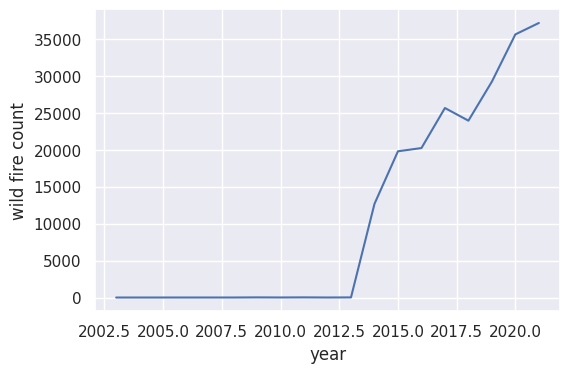

In [29]:
sns.lineplot(x=year, y=count)
plt.xlabel("year")
plt.ylabel("wild fire count")


### Split each categories for wild fire cause

Because there are too many missing values for these three attributes, the latter two account for most of them, so the null filling method cannot be used; if all the null values are removed, there is insufficient analysis data, so focus on analysis FireCause. There are too many null values in “FireCause” , “FireCauseGeneral” and “FireCauseSpecific”, especially the latter 2. We can’t fill the null with appropriate value; If all the null values are removed, there is insufficient analysis data, so the FireCause attribute is analyzed. This attribute has smaller portion of missing values.
For null values in FireCause, classify them directly as Unknown.

In [30]:
filterred_df.select("FireCause", "FireCauseGeneral", "FireCauseSpecific").show()

+---------+-------------------+-------------------+
|FireCause|   FireCauseGeneral|  FireCauseSpecific|
+---------+-------------------+-------------------+
|    Human|          Equipment|  Farming Equipment|
|  Unknown|               null|               null|
|    Human|               null|               null|
|     null|               null|               null|
|     null|               null|               null|
|    Human|         Incendiary|Habitat Improvement|
|  Unknown|               null|               null|
|  Natural|          Lightning|               null|
|    Human|Debris/Open Burning|             Barrel|
|    Human|               null|               null|
|    Human|Debris/Open Burning|               null|
|  Natural|               null|               null|
|     null|               null|               null|
|    Human|            Camping|               null|
|     null|               null|               null|
|    Human|               null|               null|
|  Natural| 

In [31]:
# For the null value in FireCause, directly classify it as Unknown 
filterred_df = filterred_df.na.fill(value="Unknown", subset=['FireCause'])


In [32]:
filterred_df.groupBy("FireCause").count().show()

+------------+-----+
|   FireCause|count|
+------------+-----+
|     Unknown|60853|
|Undetermined|25171|
|       Human|75951|
|     Natural|42415|
+------------+-----+



In [33]:
# human cause
filterred_df.filter(df.FireCause == 'Human').groupBy("year").count().orderBy("year").show()

+----+-----+
|year|count|
+----+-----+
|2010|    1|
|2014| 2853|
|2015| 5741|
|2016| 8581|
|2017| 9265|
|2018| 9393|
|2019|10280|
|2020|15816|
|2021|14021|
+----+-----+



In [34]:
# natural cause
filterred_df.filter(df.FireCause == 'Natural').groupBy("year").count().orderBy("year").show()

+----+-----+
|year|count|
+----+-----+
|2014| 4929|
|2015| 6361|
|2016| 4495|
|2017| 5692|
|2018| 5197|
|2019| 5433|
|2020| 4646|
|2021| 5662|
+----+-----+



In [35]:
## The unknown is all blamed on humans
filterred_df.filter((df.FireCause == 'Human') | (df.FireCause == 'Unknown') ).groupBy("year").count().orderBy("year").show()

+----+-----+
|year|count|
+----+-----+
|2008|    2|
|2009|   17|
|2010|    5|
|2011|   20|
|2012|    4|
|2013|   15|
|2014| 2890|
|2015| 5801|
|2016| 8712|
|2017| 9365|
|2018|14996|
|2019|21743|
|2020|29112|
|2021|17696|
+----+-----+



In [36]:
## The unknown is all blamed on Natural
filterred_df.filter((df.FireCause == 'Natural') | (df.FireCause == 'Unknown')).groupBy("year").count().orderBy("year").show()

+----+-----+
|year|count|
+----+-----+
|2008|    2|
|2009|   17|
|2010|    4|
|2011|   20|
|2012|    4|
|2013|   15|
|2014| 4966|
|2015| 6421|
|2016| 4626|
|2017| 5792|
|2018|10800|
|2019|16896|
|2020|17942|
|2021| 9337|
+----+-----+



The figures below show
1.	Change in the number of all forest fires with the year
2.	Change of the number of forest fires with different causes with the year
 
 We can see from below picture, the purple broken line is an artificial category, and the forest fires caused by artificial factors increase obviously every year. The green line is a natural cause and it can be seen that there is not much change from year to year.
There are two undetermined fire causes, unknown and undetermined, which also increase over time as a whole, but we are not sure whether they are man-made or natural. The only certainty is that in the known data, the number of man-made fires increases over time and the number of natural fires remains essentially unchanged.
Of course, these unknown causes may also be caused by climate. According to the researchers' findings(https://www.worldweatherattribution.org/western-north-american-extreme-heat-virtually-impossible-without-human-caused-climate-change/), climate change is also an important reason for the frequent occurrence of forest fires.



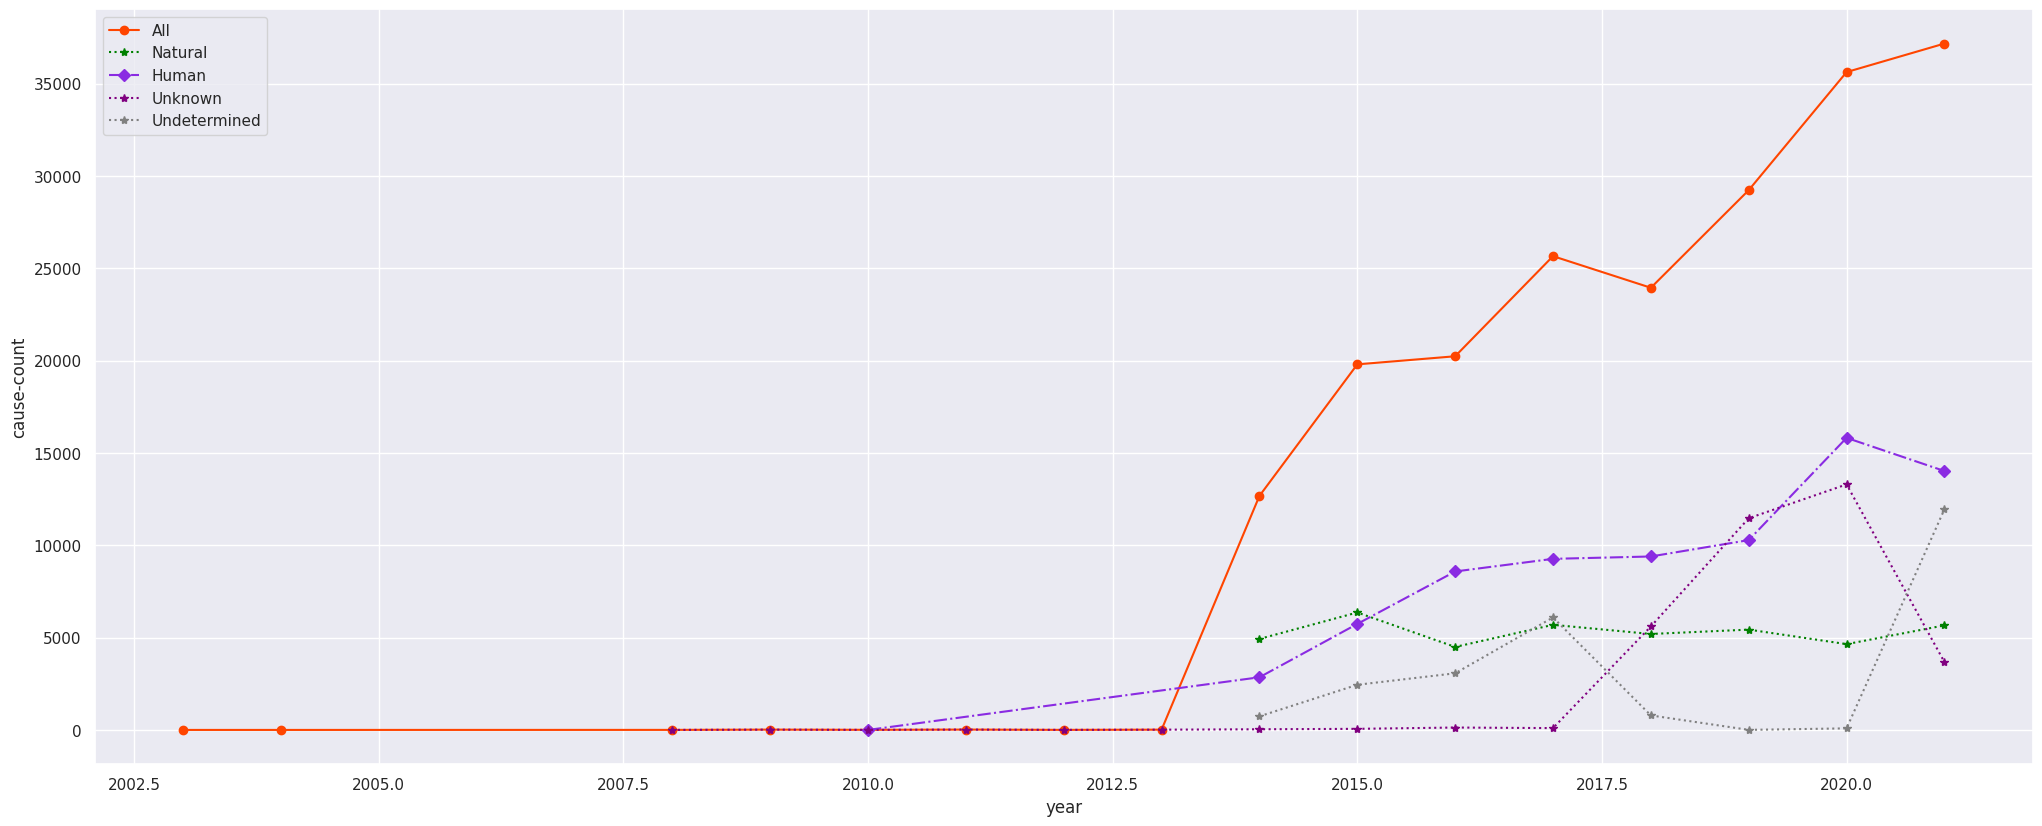

In [37]:
year_count = filterred_df.groupBy("year").count().orderBy("year").collect()
Natural = filterred_df.filter((df.FireCause == 'Natural')).groupBy("year").count().orderBy("year").collect()
Human = filterred_df.filter((df.FireCause == 'Human')).groupBy("year").count().orderBy("year").collect()
Unknown = filterred_df.filter((df.FireCause == 'Unknown')).groupBy("year").count().orderBy("year").collect()
Undetermined = filterred_df.filter((df.FireCause == 'Undetermined')).groupBy("year").count().orderBy("year").collect()

plt.figure(figsize=(25, 10))
plt.rcParams['figure.dpi'] = 150

plt.plot([int(i[0]) for i in year_count], [int(i[1]) for i in year_count], color='orangered', marker='o', linestyle='-', label='All')
plt.plot([int(i[0]) for i in Natural], [int(i[1]) for i in Natural], color='green', marker='*', linestyle=':', label='Natural')
plt.plot([int(i[0]) for i in Human], [int(i[1]) for i in Human], color='blueviolet', marker='D', linestyle='-.', label='Human')
plt.plot([int(i[0]) for i in Unknown], [int(i[1]) for i in Unknown], color='purple', marker='*', linestyle=':', label='Unknown')
plt.plot([int(i[0]) for i in Undetermined], [int(i[1]) for i in Undetermined], color='gray', marker='*', linestyle=':', label='Undetermined')

plt.legend()  #
# plt.xticks(x, names, rotation=45)
plt.xlabel("year")  # 
plt.ylabel("cause-count")  # 
plt.show()

In [38]:
filterred_df.groupBy("POOState").count().show()

+--------+-----+
|POOState|count|
+--------+-----+
|   US-TN|  536|
|   US-OK| 5504|
|   US-VT|   73|
|   US-SD| 5432|
|   US-WA|10907|
|  MX-SON|    9|
|   MX-CA|    1|
|   US-IN|  227|
|   US-AL|  922|
|   US-NY|  180|
|   US-MS| 1765|
|   MX-BN|    4|
|   CA-BC|    3|
|   US-MT|14516|
|   US-NC|  777|
|   US-CT|    4|
|   US-OR|14134|
|   US-IA|  260|
|   US-NV| 4897|
|   US-GU|    2|
+--------+-----+
only showing top 20 rows



In [41]:
pdf = filterred_df.filter(filterred_df.POOState.contains("US")).select("InitialLongitude", "InitialLatitude", "FireCause")

In [42]:
pdf = pdf.dropna()

In [43]:
pdf.sample(fraction=0.2).count()

29576

In [44]:
pdf_sampled = pdf.sample(fraction=0.02)

In addition, we can also analyze the distribution of fires. It can be seen that the current data set mainly records forest fire data from the United States. There are a few points we can see are not on the mainland, this may be a mistake in the record, or is the sea island.
We can see that, the natural cause are mostly located at West coast. In addition, the middle of USA's Wild Fire mostly caused by Human.

In [45]:
import plotly.express as px
import pandas as pd

fig = px.scatter_geo(pdf_sampled.toPandas(), lat='InitialLatitude', lon='InitialLongitude', color = "FireCause", scope='usa')
fig.update_layout(
    width=800,
    height=600)

fig.show()